# Variational API quickstart

VI API is focused on solving regular problems when utilizing posterior distributions. Common usecases that can be solved with this module are the following:

* Get Random Generator that samples from posterior and comutes some expression
* Get Monte Carlo approximation of expectation, variance and other statistics
* Remove symbolic dependence on PyMC3 random nodes and be able to call `.eval()`
* Make a bridge to arbitrary theano code

Sounds good, doesn't it?

Moreover there are a lot of inference methods that have similar API so you are free to choose what fits the best for the problem

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm
import theano

## Basic setup
We do not need complex models to play with VI API, instead we'll have a simple mixture model

In [2]:
w = pm.floatX([.2, .8])
mu = pm.floatX([-.3, .5])
sd = pm.floatX([.1, .1])
with pm.Model() as model:
    x = pm.NormalMixture('x', w=w, mu=mu, sd=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

We can't compute analytical expectations quickly here. Instead we can get approximations for it with MC methods. Lets use NUTS first. It required these variables to be in deterministic list

In [3]:
with model:
    pm.Deterministic('x2', x2)
    pm.Deterministic('sin_x', sin_x)

In [4]:
with model:
    trace = pm.sample(14000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 5.2899:   1%|          | 2073/200000 [00:00<00:19, 9930.81it/s]
Convergence archived at 2900
Interrupted at 2,900 [1%]: Average Loss = 6.0938
100%|██████████| 14500/14500 [00:06<00:00, 2102.36it/s]


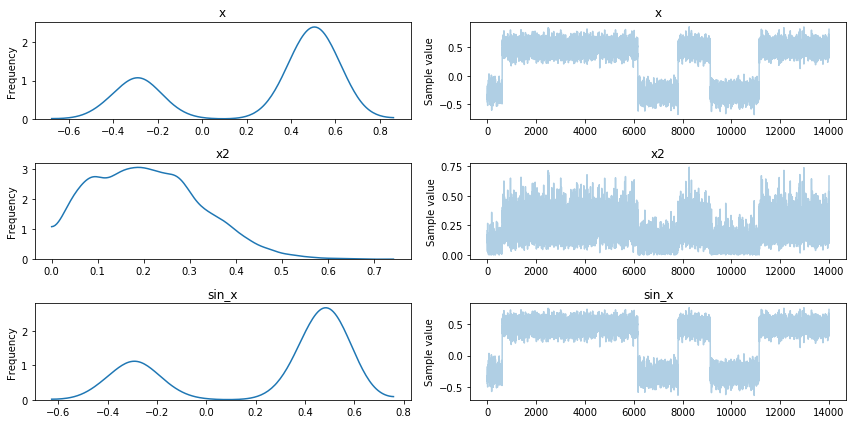

In [5]:
pm.traceplot(trace);

Looks good, we can see multomodality matters. Moreover we have samples for $x^2$ and $sin(x)$. There is one drawback, you should know in advance what exactly you want to see in trace and call `Deterministic(.)` on it.

VI API is about the opposite approach. You do inference on model, then experiments come after. Let's do the same setup without deterministics

In [6]:
with pm.Model() as model:
    x = pm.NormalMixture('x', w=w, mu=mu, sd=sd, dtype=theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

And calculate ADVI approximation

In [7]:
with model:
    mean_field = pm.fit(method='advi')

Average Loss = 2.0589: 100%|██████████| 10000/10000 [00:00<00:00, 11911.36it/s]
Finished [100%]: Average Loss = 2.056


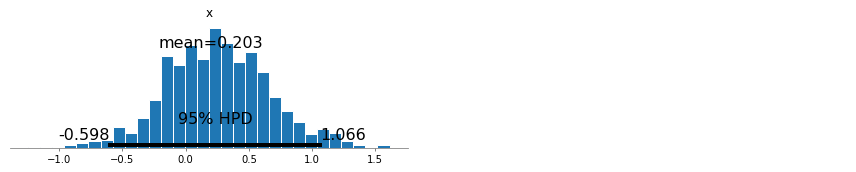

In [8]:
pm.plot_posterior(mean_field.sample(1000));

You can see no multimodality here. Notice that we did a lot more iterations as we did not check convergence of inference. That can be done via callbacks.

In [9]:
help(pm.callbacks.CheckParametersConvergence)

Help on class CheckParametersConvergence in module pymc3.variational.callbacks:

class CheckParametersConvergence(Callback)
 |  Convergence stopping check
 |  
 |  Parameters
 |  ----------
 |  every : int
 |      check frequency
 |  tolerance : float
 |      if diff norm < tolerance : break
 |  diff : str
 |      difference type one of {'absolute', 'relative'}
 |  ord : {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
 |      see more info in :func:`numpy.linalg.norm`
 |  
 |  Examples
 |  --------
 |  >>> with model:
 |  ...     approx = pm.fit(
 |  ...         n=10000, callbacks=[
 |  ...             CheckParametersConvergence(
 |  ...                 every=50, diff='absolute',
 |  ...                 tolerance=1e-4)
 |  ...         ]
 |  ...     )
 |  
 |  Method resolution order:
 |      CheckParametersConvergence
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, approx, _, i)
 |      Call self as a function.
 |  
 |  __init__(self, e

Let's use defaults as they seem to be reasonable

In [10]:
with model:
    mean_field = pm.fit(method='advi', callbacks=[pm.callbacks.CheckParametersConvergence()])

Average Loss = 1.8828: 100%|██████████| 10000/10000 [00:00<00:00, 11075.90it/s]
Finished [100%]: Average Loss = 1.8782


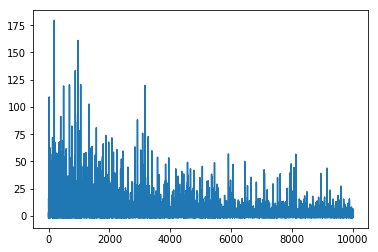

In [11]:
plt.plot(mean_field.hist);

Hmm, something went wrong, we again did a lot of iterations. The reason is that mean of ADVI approximation is close to 0 and taking relative difference is unstable for checking convergence

In [12]:
with model:
    mean_field = pm.fit(method='advi', callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])

Average Loss = 3.3035:  45%|████▌     | 4535/10000 [00:00<00:00, 11472.18it/s]
Convergence archived at 5400
Interrupted at 5,400 [54%]: Average Loss = 4.7803


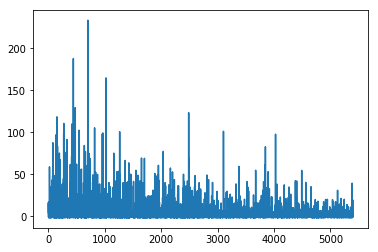

In [13]:
plt.plot(mean_field.hist);

## Tracking parameters

That's much beter. There is another usefull callback in pymc3. It makes available to track arbitrary statistics during inference. One of them (but sometimes memory consuming) is tracking parameters. In function `pm.fit` we do not have direct access to approximation before inference. But tracking parameters requires it. To cope with this problem we can use Object Oriented API for inference.

In [14]:
with model:
    advi = pm.ADVI()

In [15]:
advi.approx

Different approximations have different parameters. In MeanField case we use $\rho$ and $\mu$ (inspired by [Bayes by BackProp](https://arxiv.org/abs/1505.05424))

In [59]:
advi.approx.shared_params

{'mu': mu, 'rho': rho}

But having convinient shortcuts happens to be usefull sometimes. One of most frequent cases is specifying mass matrix for NUTS

In [16]:
advi.approx.mean.eval(), advi.approx.std.eval()

(array([ 0.34], dtype=float32), array([ 0.69314718], dtype=float32))

That's what we want

In [17]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)

In [58]:
print(pm.callbacks.Tracker.__doc__)


    Helper class to record arbitrary stats during VI

    It is possible to pass a function that takes no arguments
    If call fails then (approx, hist, i) are passed


    Parameters
    ----------
    kwargs : key word arguments
        keys mapping statname to callable that records the stat

    Examples
    --------
    Consider we want time on each iteration    
    >>> import time
    >>> tracker = Tracker(time=time.time)
    >>> with model:
    ...     approx = pm.fit(callbacks=[tracker])
    
    Time can be accessed via :code:`tracker['time']` now
    For more complex summary one can use callable that takes
    (approx, hist, i) as arguments
    >>> with model:
    ...     my_callable = lambda ap, h, i: h[-1]
    ...     tracker = Tracker(some_stat=my_callable)
    ...     approx = pm.fit(callbacks=[tracker])
    
    Multiple stats are valid too
    >>> with model:
    ...     tracker = Tracker(some_stat=my_callable, time=time.time)
    ...     approx = pm.fit(callbacks=[tr

Now, calling `advi.fit` will make inference but in a slightly more flexible way.

In [18]:
approx = advi.fit(20000, callbacks=[tracker])

Average Loss = 2.0821: 100%|██████████| 20000/20000 [00:02<00:00, 8163.59it/s]
Finished [100%]: Average Loss = 2.0838


We can now plot inference results ans trace for parameters

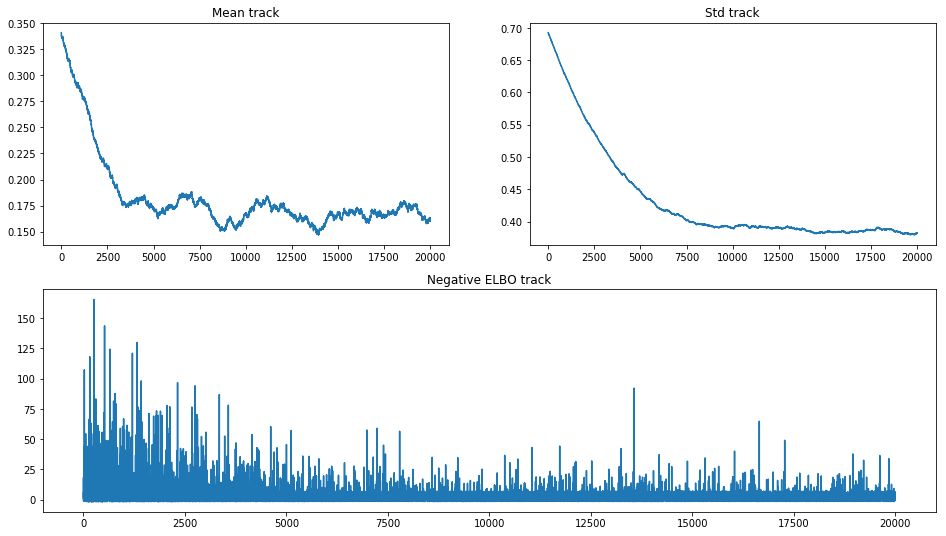

In [19]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

That picture is very informative. We can see how poor mean converges and that different values for it do not change elbo significantly. As we are using OO API, we can continue inference to get some visual convergence

In [20]:
approx = advi.fit(100000, callbacks=[tracker])

Average Loss = 2.197: 100%|██████████| 100000/100000 [00:12<00:00, 8257.31it/s]
Finished [100%]: Average Loss = 2.2027


And this picture again

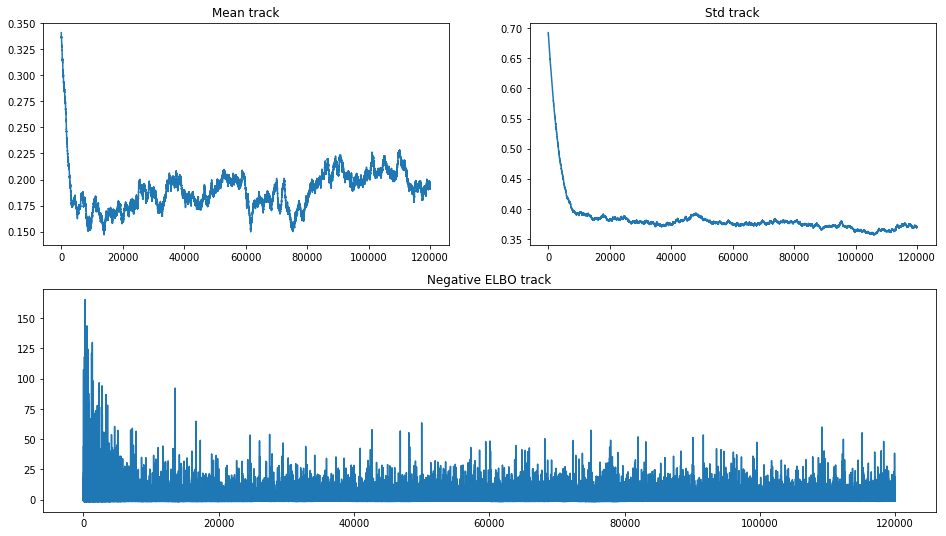

In [21]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

We are still uncertain for the true optimum of ADVI inference. Let's compare results with old NUTS trace

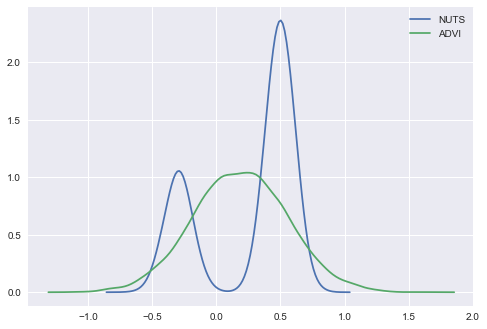

In [22]:
import seaborn as sns
ax = sns.kdeplot(trace['x'], label='NUTS');
sns.kdeplot(approx.sample(10000)['x'], label='ADVI');

To cope with multimidality we can instead use SVGD that creates approximation based on large number of particles

In [23]:
with model:
    svgd_approx = pm.fit(300, method='svgd', inf_kwargs=dict(n_particles=1000), 
                         obj_optimizer=pm.sgd(learning_rate=0.01))

100%|██████████| 300/300 [00:37<00:00,  8.10it/s]


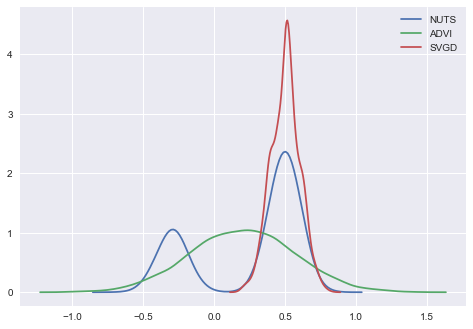

In [24]:
ax = sns.kdeplot(trace['x'], label='NUTS');
sns.kdeplot(approx.sample(10000)['x'], label='ADVI');
sns.kdeplot(svgd_approx.sample(2000)['x'], label='SVGD');

Seems like our SVGD got stuck in the mode. The reason is just bad initialization. We can solve the problem using larger `jitter` in initialization

In [25]:
with model:
    svgd_approx = pm.fit(300, method='svgd', 
                         inf_kwargs=dict(n_particles=1000, jitter=1), 
                         obj_optimizer=pm.sgd(learning_rate=0.01))

100%|██████████| 300/300 [00:38<00:00,  6.59it/s]


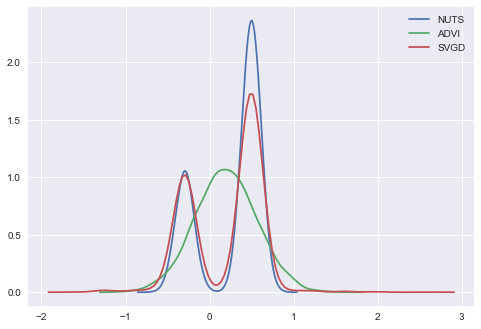

In [26]:
ax = sns.kdeplot(trace['x'], label='NUTS');
sns.kdeplot(approx.sample(10000)['x'], label='ADVI');
sns.kdeplot(svgd_approx.sample(2000)['x'], label='SVGD');

Looks much better. We have multimodal approximation with SVGD. Now it is possible to do arbitrary things with this variational approximation. For example we can create the same things as in the first model: $x^2$ and $sin(x)$

In [27]:
a = x**2
b = pm.math.sin(x)

## Replacements

To apply approximation to an arbitrary expression you should use `approx.apply_replacements` or `approx.sample_node` methods

In [28]:
help(svgd_approx.apply_replacements)

Help on method apply_replacements in module pymc3.variational.opvi:

apply_replacements(node, deterministic=False, include=None, exclude=None, more_replacements=None) method of pymc3.variational.approximations.Empirical instance
    Replace variables in graph with variational approximation. By default, replaces all variables
    
    Parameters
    ----------
    node : Theano Variables (or Theano expressions)
        node or nodes for replacements
    deterministic : bool
        whether to use zeros as initial distribution
        if True - zero initial point will produce constant latent variables
    include : `list`
        latent variables to be replaced
    exclude : `list`
        latent variables to be excluded for replacements
    more_replacements : `dict`
        add custom replacements to graph, e.g. change input source
    
    Returns
    -------
    node(s) with replacements



### basic usage

In [29]:
as_ = svgd_approx.apply_replacements(a)

In [30]:
as_.eval()

array(0.3580327033996582, dtype=float32)

In [31]:
as_.eval()

array(0.5414913296699524, dtype=float32)

In [32]:
as_.eval()

array(0.24770502746105194, dtype=float32)

Every time we get different value for the same theano node. That is because it is stochastic. After replacements we are free and do not depend on pymc3 model. We now depend on approximation. Changing it will change the distribution for stochastic nodes

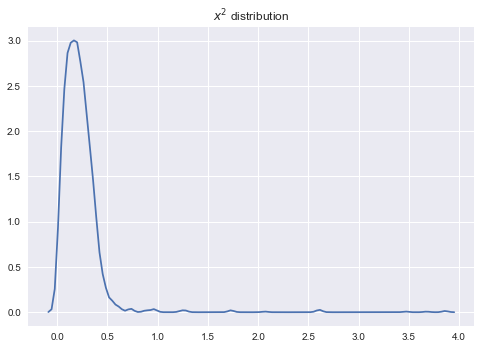

In [33]:
import numpy as np
sns.kdeplot(np.array([as_.eval() for _ in range(2000)]));
plt.title('$x^2$ distribution');

There is a more convinient way to get lots of samples at once: `sample_node`

In [34]:
ass_ = svgd_approx.sample_node(a, size=1000)

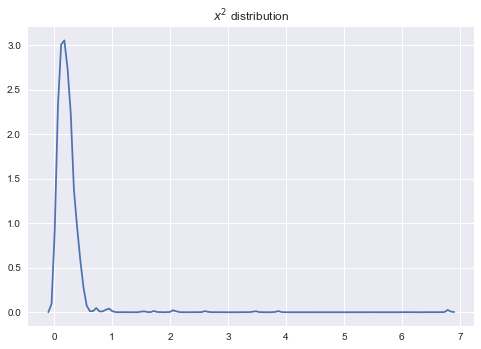

In [35]:
sns.kdeplot(ass_.eval());
plt.title('$x^2$ distribution');

We get approximately the same picture 

In [36]:
ass_.eval().shape

(1000,)

In [37]:
as_.eval().shape

()

In `sample_node` function additional dimension is added in the first position. So taking expectations, calculating variance is done by `axis=0`

In [38]:
ass_.var(0).eval()  # variance

array(0.11649802327156067, dtype=float32)

In [39]:
ass_.mean(0).eval()  # mean

array(0.23636947572231293, dtype=float32)

Symbolic sample size is OK too

In [61]:
i = theano.tensor.iscalar('i')
i.tag.test_value = 1
ass2_ = svgd_approx.sample_node(a, size=i)

In [63]:
ass2_.eval({i: 100}).shape, ass2_.eval({i: 10000}).shape

((100,), (10000,))

But unfortunately only scalar size is supported.

### creating custom fuction
What about mode_replacements argument, it can be very usefull sometimes. Suppose you have the following setup:

In [40]:
train_data = theano.shared(np.random.rand(10, 3))

In [41]:
prediction = train_data * sin_x

calling prediction right now will raise `MissingInputError`. We again need replacements. But after training we no more need `train_data`, we usually want a function that makes prediction for a given training point.

In [42]:
input_data = theano.tensor.matrix()
prediction = svgd_approx.apply_replacements(prediction, more_replacements={train_data:input_data})

In [43]:
prediction_f = theano.function([input_data], prediction)

In [44]:
prediction_f(np.array([[-1., 0, 1.]], 'float32'))

array([[-0.3722021,  0.       ,  0.3722021]], dtype=float32)

In [45]:
prediction_f(np.array([[-1., 0, 1.]], 'float32'))

array([[-0.52397037,  0.        ,  0.52397037]], dtype=float32)

We again get different samples every time

### converting trace to Approximation
There is a neat feature to convert any trace to Approximation. It will have the same API as approximations above with same `apply_replacemets/sample_node` methods 

In [46]:
trace_approx = pm.Empirical(trace, model=model)

In [47]:
trace_approx

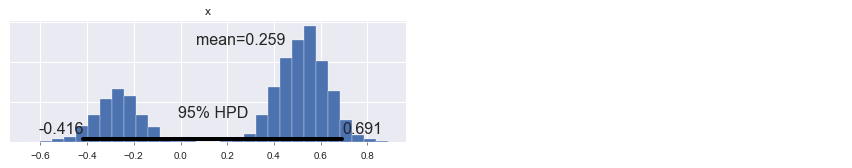

In [49]:
pm.plot_posterior(trace_approx.sample(10000));

## Minibatches
Another usefull feature is Minibatch training. When your data is too large there is no reason to use full dataset to compute grasients. There is a nice API in pymc3 to handle these cases. You can reference `pm.Minibatch` for details

In [50]:
# easy workflow like with regular tensor
issubclass(pm.Minibatch, theano.tensor.TensorVariable)

True

### Data

In [51]:
data = np.random.rand(400000, 100)    # initial
data *= np.random.randint(1, 10, size=(100,))# our std
data += np.random.rand(100) * 10    # our mean

### no minibatch inference

In [52]:
with pm.Model() as model:
    mu = pm.Flat('mu', shape=(100,))
    sd = pm.HalfNormal('sd', shape=(100,))
    lik = pm.Normal('lik', mu, sd, observed=data)

In [53]:
with model:
    advifit = pm.fit()

Average Loss = 4.7307e+09:   0%|          | 8/10000 [00:14<4:53:42,  1.76s/it]
Interrupted at 8 [0%]: Average Loss = 4.9355e+09


Inference is too slow

### minibatch inference

In [54]:
X = pm.Minibatch(data, batch_size=500)

with pm.Model() as model:
    mu = pm.Flat('mu', shape=(100,))
    sd = pm.HalfNormal('sd', shape=(100,))
    lik = pm.Normal('lik', mu, sd, observed=X, total_size=data.shape)

In [55]:
with model:
    advifit = pm.fit()

Average Loss = 1.1898e+08: 100%|██████████| 10000/10000 [00:10<00:00, 963.93it/s]
Finished [100%]: Average Loss = 1.1893e+08


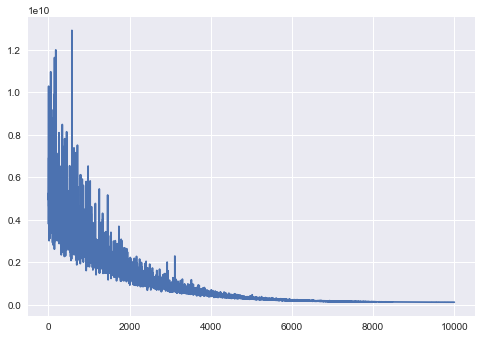

In [56]:
plt.plot(advifit.hist);

Minibatch inference is faster. Full documantation for minibatch can be accesed via docstring. Multidimensional minibatches can be needed for some corner cases where you do matrix factorization or model is very wide.

In [57]:
print(pm.Minibatch.__doc__)

Multidimensional minibatch that is pure TensorVariable

    Parameters
    ----------
    data : :class:`ndarray`
        initial data
    batch_size : `int` or `List[int|tuple(size, random_seed)]`
        batch size for inference, random seed is needed 
        for child random generators
    dtype : `str`
        cast data to specific type
    broadcastable : tuple[bool]
        change broadcastable pattern that defaults to `(False, ) * ndim`
    name : `str`
        name for tensor, defaults to "Minibatch"
    random_seed : `int`
        random seed that is used by default
    update_shared_f : `callable`
        returns :class:`ndarray` that will be carefully 
        stored to underlying shared variable
        you can use it to change source of 
        minibatches programmatically 
    in_memory_size : `int` or `List[int|slice|Ellipsis]`
        data size for storing in theano.shared

    Attributes
    ----------
    shared : shared tensor
        Used for storing data
    mini